# Sequence Classification 

This is a example of how to use Recurrent Neural networks for clasify sequence(many to one) 

In [1]:
import numpy as np
import six

def pad_sequences(sequences, maxlen=None, dtype='int32',
                  padding='pre', truncating='pre', value=0.):
    if not hasattr(sequences, '__len__'):
        raise ValueError('`sequences` must be iterable.')
    lengths = []
    for x in sequences:
        if not hasattr(x, '__len__'):
            raise ValueError('`sequences` must be a list of iterables. '
                             'Found non-iterable: ' + str(x))
        lengths.append(len(x))

    num_samples = len(sequences)
    if maxlen is None:
        maxlen = np.max(lengths)

    # take the sample shape from the first non empty sequence
    # checking for consistency in the main loop below.
    sample_shape = tuple()
    for s in sequences:
        if len(s) > 0:
            sample_shape = np.asarray(s).shape[1:]
            break

    is_dtype_str = np.issubdtype(dtype, np.str_) or np.issubdtype(dtype, np.unicode_)
    if isinstance(value, six.string_types) and dtype != object and not is_dtype_str:
        raise ValueError("`dtype` {} is not compatible with `value`'s type: {}\n"
                         "You should set `dtype=object` for variable length strings."
                         .format(dtype, type(value)))

    x = np.full((num_samples, maxlen) + sample_shape, value, dtype=dtype)
    for idx, s in enumerate(sequences):
        if not len(s):
            continue  # empty list/array was found
        if truncating == 'pre':
            trunc = s[-maxlen:]
        elif truncating == 'post':
            trunc = s[:maxlen]
        else:
            raise ValueError('Truncating type "%s" '
                             'not understood' % truncating)

        # check `trunc` has expected shape
        trunc = np.asarray(trunc, dtype=dtype)
        if trunc.shape[1:] != sample_shape:
            raise ValueError('Shape of sample %s of sequence at position %s '
                             'is different from expected shape %s' %
                             (trunc.shape[1:], idx, sample_shape))

        if padding == 'post':
            x[idx, :len(trunc)] = trunc
        elif padding == 'pre':
            x[idx, -len(trunc):] = trunc
        else:
            raise ValueError('Padding type "%s" not understood' % padding)
    return x

def to_categorical(y, num_classes=None, dtype='float32'):
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

class TemporalOrderExp6aSequence():
    """
    From Hochreiter&Schmidhuber(1997):
        The goal is to classify sequences. Elements and targets are represented locally
        (input vectors with only one non-zero bit). The sequence starts with an B, ends
        with a E (the "trigger symbol") and otherwise consists of randomly chosen symbols
        from the set {a, b, c, d} except for two elements at positions t1 and t2 that are
        either X or Y . The sequence length is randomly chosen between 100 and 110, t1 is
        randomly chosen between 10 and 20, and t2 is randomly chosen between 50 and 60.
        There are 4 sequence classes Q, R, S, U which depend on the temporal order of X and Y.
        The rules are:
            X, X -> Q,
            X, Y -> R,
            Y , X -> S,
            Y , Y -> U.
    """

    def __init__(self, length_range=(100, 111), t1_range=(10, 21), t2_range=(50, 61),
                 batch_size=32, seed=None):

        self.classes = ['Q', 'R', 'S', 'U']
        self.n_classes = len(self.classes)

        self.relevant_symbols = ['X', 'Y']
        self.distraction_symbols = ['a', 'b', 'c', 'd']
        self.start_symbol = 'B'
        self.end_symbol = 'E'

        self.length_range = length_range
        self.t1_range = t1_range
        self.t2_range = t2_range
        self.batch_size = batch_size

        if seed is not None:
            np.random.seed(seed)

        all_symbols = self.relevant_symbols + self.distraction_symbols + \
                      [self.start_symbol] + [self.end_symbol]
        self.n_symbols = len(all_symbols)
        self.s_to_idx = {s: n for n, s in enumerate(all_symbols)}
        self.idx_to_s = {n: s for n, s in enumerate(all_symbols)}

        self.c_to_idx = {c: n for n, c in enumerate(self.classes)}
        self.idx_to_c = {n: c for n, c in enumerate(self.classes)}

    def generate_pair(self):
        length = np.random.randint(self.length_range[0], self.length_range[1])
        t1 = np.random.randint(self.t1_range[0], self.t1_range[1])
        t2 = np.random.randint(self.t2_range[0], self.t2_range[1])

        x = np.random.choice(self.distraction_symbols, length)
        x[0] = self.start_symbol
        x[-1] = self.end_symbol

        y = np.random.choice(self.classes)
        if y == 'Q':
            x[t1], x[t2] = self.relevant_symbols[0], self.relevant_symbols[0]
        elif y == 'R':
            x[t1], x[t2] = self.relevant_symbols[0], self.relevant_symbols[1]
        elif y == 'S':
            x[t1], x[t2] = self.relevant_symbols[1], self.relevant_symbols[0]
        else:
            x[t1], x[t2] = self.relevant_symbols[1], self.relevant_symbols[1]

        return ''.join(x), y

    # encoding/decoding single instance version

    def encode_x(self, x):
        idx_x = [self.s_to_idx[s] for s in x]
        return to_categorical(idx_x, num_classes=self.n_symbols)

    def encode_y(self, y):
        idx_y = self.c_to_idx[y]
        return to_categorical(idx_y, num_classes=self.n_classes)

    def decode_x(self, x):
        x = x[np.sum(x, axis=1) > 0]    # remove padding
        return ''.join([self.idx_to_s[pos] for pos in np.argmax(x, axis=1)])

    def decode_y(self, y):
        return self.idx_to_c[np.argmax(y)]

    # encoding/decoding batch versions

    def encode_x_batch(self, x_batch):
        return pad_sequences([self.encode_x(x) for x in x_batch],
                             maxlen=self.length_range[1])

    def encode_y_batch(self, y_batch):
        return np.array([self.encode_y(y) for y in y_batch])

    def decode_x_batch(self, x_batch):
        return [self.decode_x(x) for x in x_batch]

    def decode_y_batch(self, y_batch):
        return [self.idx_to_c[pos] for pos in np.argmax(y_batch, axis=1)]

    def __len__(self):
        """ Let's assume 1000 sequences as the size of data. """
        return int(1000. / self.batch_size)

    def __getitem__(self, index):
        batch_x, batch_y = [], []
        for _ in range(self.batch_size):
            x, y = self.generate_pair()
            batch_x.append(x)
            batch_y.append(y)
        return self.encode_x_batch(batch_x), self.encode_y_batch(batch_y)

    class DifficultyLevel:
        """ On HARD, settings are identical to the original settings from the '97 paper."""
        EASY, NORMAL, MODERATE, HARD, NIGHTMARE = range(5)

    @staticmethod
    def get_predefined_generator(difficulty_level, batch_size=32, seed=8382):
        EASY = TemporalOrderExp6aSequence.DifficultyLevel.EASY
        NORMAL = TemporalOrderExp6aSequence.DifficultyLevel.NORMAL
        MODERATE = TemporalOrderExp6aSequence.DifficultyLevel.MODERATE
        HARD = TemporalOrderExp6aSequence.DifficultyLevel.HARD

        if difficulty_level == EASY:
            length_range = (7, 9)
            t1_range = (1, 3)
            t2_range = (4, 6)
        elif difficulty_level == NORMAL:
            length_range = (30, 41)
            t1_range = (2, 6)
            t2_range = (20, 28)
        elif difficulty_level == MODERATE:
            length_range = (60, 81)
            t1_range = (10, 21)
            t2_range = (45, 55)
        elif difficulty_level == HARD:
            length_range = (100, 111)
            t1_range = (10, 21)
            t2_range = (50, 61)
        else:
            length_range = (300, 501)
            t1_range = (10, 81)
            t2_range = (250, 291)
        return TemporalOrderExp6aSequence(length_range, t1_range, t2_range,
                                          batch_size, seed)
    

## Dataset Exploration

In [2]:
# Create a data generator

QRSU = TemporalOrderExp6aSequence()

example_generator = QRSU.get_predefined_generator(
    difficulty_level=QRSU.DifficultyLevel.EASY,
    batch_size=32,
)

example_batch = example_generator[1]
print(f'The return type is a {type(example_batch)} with length {len(example_batch)}.')
print(f'The first item in the tuple is the batch of sequences with shape {example_batch[0].shape}.')
print(f'The first element in the batch of sequences is:\n {example_batch[0][0, :, :]}')
print(f'The second item in the tuple is the corresponding batch of class labels with shape {example_batch[1].shape}.')
print(f'The first element in the batch of class labels is:\n {example_batch[1][0, :]}')

The return type is a <class 'tuple'> with length 2.
The first item in the tuple is the batch of sequences with shape (32, 9, 8).
The first element in the batch of sequences is:
 [[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1]]
The second item in the tuple is the corresponding batch of class labels with shape (32, 4).
The first element in the batch of class labels is:
 [1. 0. 0. 0.]


In [3]:
# Decoding the first sequence
sequence_decoded = example_generator.decode_x(example_batch[0][0, :, :])
print(f'The sequence is: {sequence_decoded}')

# Decoding the class label of the first sequence
class_label_decoded = example_generator.decode_y(example_batch[1][0])
print(f'The class label is: {class_label_decoded}')

The sequence is: BbXcXcbE
The class label is: Q


## Define NN

In [14]:
import torch
import torch.nn as nn

In [33]:
#set the random seed for reproducible products
torch.manual_seed(1)

# this is a simple RNN
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__() # this call the base class constructor
        # NN layers assigned as attributes of a module subclass
        # have their parameters registered for training automatically.
        self.rnn = torch.nn.RNN(input_size, hidden_size, nonlinearity='relu', batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # The RNN returns its hidden state but here not use while the RNN can
        # also take a hidden state as input, the RNN gets passed a hidden 
        # state initialized zeros by default
        h = self.rnn(x)[0]
        x = self.linear(h)
        
        return x

# this is simple LSTM
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h = self.lstm(x)[0]
        x = self.linear(h)

        return x

    def get_states_across_time(self, x):
        h_c = None
        h_list, c_list = list(), list()

        with torch.no_grad():
            for t in range(x.size(1)):
                h_c = self.lstm(x[:, [t], :], h_c)[1]
                h_list.append(h_c[0])
                c_list.append(h_c[1])
            h = torch.cat(h_list)
            c = torch.cat(c_list)

            return h, c


## Training

In [16]:
def train(model, train_data_gen, criterion, optimizer, device):
    # set the model to training mode. It turnn on layers that would otherwise
    # behave differently during evaluation, such as dropout
    model.train()

    # Store the number of sequence that were calssified correctly
    num_correct = 0

    # Iterate over every batch of sequences. the length of a data generator 
    # is defined as the number of batches requires to produce a total of 1000
    # sequences given a batch_size
    for batch_idx in range(len(train_data_gen)):

        # Request a batch of sequences and class labels
        data, target = train_data_gen[batch_idx]
        # convert them into tensors of the correct type, and the then send them 
        # to the appropiate device
        data, target = torch.from_numpy(data).float().to(device), \
                        torch.from_numpy(target).long().to(device)

        # do forward
        output = model(data) # step 1

        # Pick only the output corresponding to last sequence element
        output = output[:, -1, :]

        # Compute de the loss function for this batch. For CrossEntroyLoss,
        # the second argument most be a tensor of class indices instead of one-hot
        #enconded class labels. One approach is to take advantage of the one-hot
        # encoding of the target and call argmax along its second dimension to 
        # create a tensor of shape (batch_size) containing the index of the class
        # label that was hot for each sequence.
        target = target.argmax(dim=1)

        loss = criterion(output, target) # step 2 do loss function

        # Clear the gradient buffer of the optimized parameters.
        # it will prevent accumulated gradients from previous batch.
        optimizer.zero_grad() # step 3

        loss.backward() # step 4 backpropagation

        optimizer.step() # step 5 gradiend descent

        y_pred = output.argmax(dim=1)
        num_correct += (y_pred == target).sum().item()

    return num_correct,  loss.item()

## Testing

In [17]:
def test(model, test_data_gen, criterion, device):
    # set model to evaluation mode
    model.eval()

    # Store the number of sequences that were calssified correctly
    num_correct = 0

    # a context manager is used to disable gradient calculations during inference
    # to reduce memory usage, as we typically dont need the gradients at this point
    with torch.no_grad():
        for batch_idx in range(len(test_data_gen)):
            data, target = test_data_gen[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            output = model(data)
            output = output[:, -1, :]

            target = target.argmax(dim=1)
            loss = criterion(output, target)

            y_pred = output.argmax(dim=1)
            num_correct += (y_pred == target).sum().item()

    return num_correct, loss.item()

## Combine all

In [18]:
import matplotlib.pyplot as plt

In [29]:

def train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=True):
    #check device
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    #move model
    model.to(device)

    #track loss and model accuracy across epochs
    history_train = {'loss': [], 'accuracy': []}
    history_test = {'loss': [],  'accuracy': []}

    for epoch in range(max_epochs):
        # Run training loop and get accuracy
        num_correct, loss = train(model, train_data_gen, criterion, optimizer, device)
        accuracy = float(num_correct) / (len(train_data_gen) * train_data_gen.batch_size) * 100
        history_train['loss'].append(loss)
        history_train['accuracy'].append(accuracy)

        # Do the same for the testing loop
        num_correct, loss = test(model, test_data_gen, criterion, device)
        accuracy = float(num_correct) / (len(test_data_gen) * test_data_gen.batch_size) * 100
        history_test['loss'].append(loss)
        history_test['accuracy'].append(accuracy)


        if verbose or epoch + 1 == max_epochs:
            print(f'[Epoch {epoch + 1}/{max_epochs}]'
                    f" loss: {history_train['loss'][-1]:.4f}, accuracy: {history_train['accuracy'][-1]:2.2f}%" 
                    f" - test_loss: {history_test['loss'][-1]:.4f}, test_acc: {history_test['accuracy'][-1]:2.2f}%")
        
    # Generate diagnostic plots for the loss and accuracy
    fig, axes = plt.subplots(ncols=2, figsize=(9, 4.5))
    for ax, metric in zip(axes, ['loss', 'accuracy']):
        ax.plot(history_train[metric])
        ax.plot(history_test[metric])
        ax.set_xlabel('epoch', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.legend(['Train', 'Test'], loc='best')
    plt.show()    

    return model


## test RNN for 10 epochs

[Epoch 1/10] loss: 1.4394, accuracy: 23.49% - test_loss: 1.3852, test_acc: 26.11%
[Epoch 2/10] loss: 1.4087, accuracy: 25.10% - test_loss: 1.3775, test_acc: 26.41%
[Epoch 3/10] loss: 1.3787, accuracy: 22.58% - test_loss: 1.3588, test_acc: 22.38%
[Epoch 4/10] loss: 1.3510, accuracy: 27.62% - test_loss: 1.3620, test_acc: 31.96%
[Epoch 5/10] loss: 1.2895, accuracy: 38.71% - test_loss: 1.3196, test_acc: 40.02%
[Epoch 6/10] loss: 1.2044, accuracy: 45.67% - test_loss: 1.2316, test_acc: 48.99%
[Epoch 7/10] loss: 1.1297, accuracy: 50.50% - test_loss: 1.1609, test_acc: 48.89%
[Epoch 8/10] loss: 1.0142, accuracy: 54.44% - test_loss: 1.0891, test_acc: 50.20%
[Epoch 9/10] loss: 1.0098, accuracy: 56.15% - test_loss: 0.9800, test_acc: 63.51%
[Epoch 10/10] loss: 0.8904, accuracy: 66.43% - test_loss: 0.8631, test_acc: 68.75%


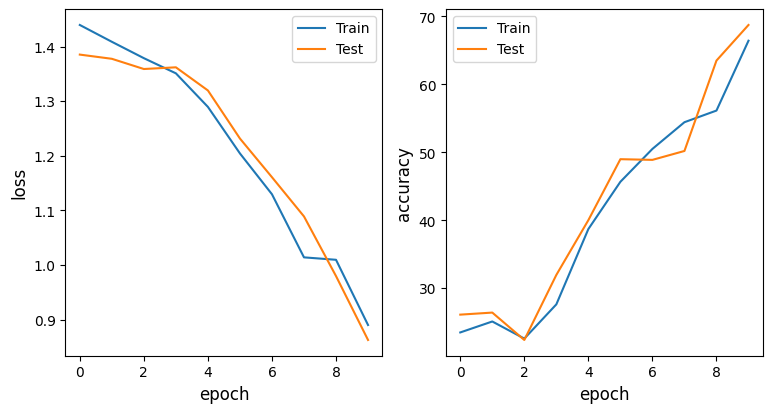

In [30]:
#setup data generator
difficulty = QRSU.DifficultyLevel.EASY
batch_size = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup RNN and training
input_size = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model = RNN(input_size, hidden_size, output_size)
criterion = torch.nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs = 10

# train 
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

In [31]:
for parameter_group in list(model.parameters()):
    print(parameter_group.size())

torch.Size([4, 8])
torch.Size([4, 4])
torch.Size([4])
torch.Size([4])
torch.Size([4, 4])
torch.Size([4])


## Test LSTM in 10 epoch

[Epoch 1/10] loss: 1.3718, accuracy: 25.10% - test_loss: 1.4314, test_acc: 23.49%
[Epoch 2/10] loss: 1.4077, accuracy: 26.92% - test_loss: 1.3899, test_acc: 23.99%
[Epoch 3/10] loss: 1.3850, accuracy: 21.37% - test_loss: 1.3571, test_acc: 23.89%
[Epoch 4/10] loss: 1.3427, accuracy: 26.61% - test_loss: 1.3738, test_acc: 25.81%
[Epoch 5/10] loss: 1.3228, accuracy: 24.29% - test_loss: 1.3426, test_acc: 31.85%
[Epoch 6/10] loss: 1.3141, accuracy: 42.04% - test_loss: 1.2911, test_acc: 32.46%
[Epoch 7/10] loss: 1.2829, accuracy: 38.10% - test_loss: 1.3027, test_acc: 36.29%
[Epoch 8/10] loss: 1.2284, accuracy: 34.88% - test_loss: 1.2759, test_acc: 28.63%
[Epoch 9/10] loss: 1.2118, accuracy: 62.80% - test_loss: 1.1529, test_acc: 86.19%
[Epoch 10/10] loss: 1.1659, accuracy: 79.54% - test_loss: 1.1017, test_acc: 81.15%


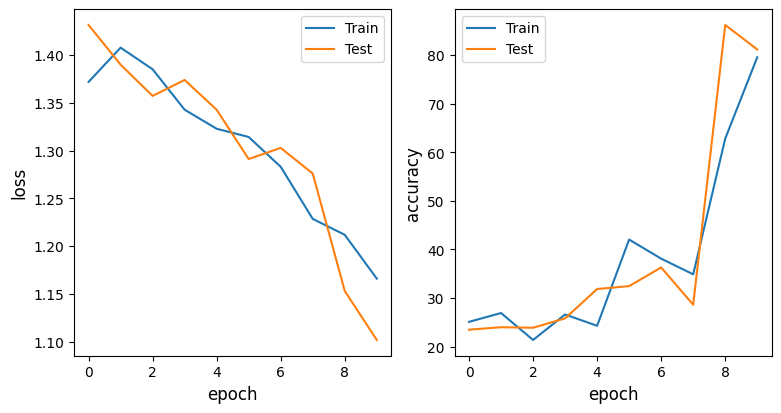

In [34]:
#setup data generator
difficulty = QRSU.DifficultyLevel.EASY
batch_size = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup RNN and training
input_size = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model = LSTM(input_size, hidden_size, output_size)
criterion = torch.nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs = 10

# train 
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

## Test RNN in 100 epoch

[Epoch 1/100] loss: 1.3334, accuracy: 25.30% - test_loss: 1.4625, test_acc: 25.10%
[Epoch 2/100] loss: 1.3894, accuracy: 26.71% - test_loss: 1.4219, test_acc: 27.12%
[Epoch 3/100] loss: 1.3881, accuracy: 28.63% - test_loss: 1.3868, test_acc: 37.00%
[Epoch 4/100] loss: 1.3468, accuracy: 32.06% - test_loss: 1.3754, test_acc: 33.27%
[Epoch 5/100] loss: 1.3699, accuracy: 28.83% - test_loss: 1.3478, test_acc: 35.28%
[Epoch 6/100] loss: 1.3328, accuracy: 35.28% - test_loss: 1.3443, test_acc: 33.06%
[Epoch 7/100] loss: 1.2801, accuracy: 31.75% - test_loss: 1.2581, test_acc: 34.07%
[Epoch 8/100] loss: 1.2858, accuracy: 33.06% - test_loss: 1.1785, test_acc: 38.71%
[Epoch 9/100] loss: 1.1892, accuracy: 37.30% - test_loss: 1.1025, test_acc: 45.77%
[Epoch 10/100] loss: 1.1222, accuracy: 48.08% - test_loss: 1.0349, test_acc: 48.08%
[Epoch 11/100] loss: 1.0909, accuracy: 49.29% - test_loss: 0.9858, test_acc: 49.80%
[Epoch 12/100] loss: 0.9129, accuracy: 49.19% - test_loss: 1.0162, test_acc: 47.48%
[

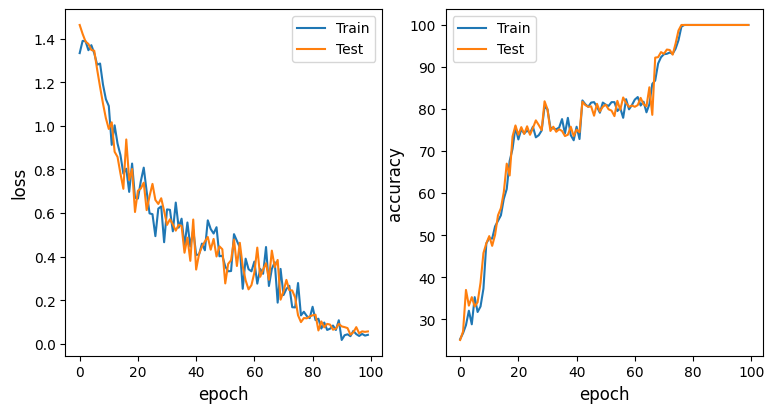

In [35]:
#setup data generator
difficulty = QRSU.DifficultyLevel.EASY
batch_size = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup RNN and training
input_size = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model = RNN(input_size, hidden_size, output_size)
criterion = torch.nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs = 100

# train 
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

## Test LSTM in 100

[Epoch 1/100] loss: 1.3919, accuracy: 27.52% - test_loss: 1.3582, test_acc: 37.60%
[Epoch 2/100] loss: 1.3214, accuracy: 30.75% - test_loss: 1.3042, test_acc: 33.27%
[Epoch 3/100] loss: 1.2244, accuracy: 46.77% - test_loss: 1.1936, test_acc: 60.69%
[Epoch 4/100] loss: 1.1451, accuracy: 67.94% - test_loss: 1.1097, test_acc: 53.12%
[Epoch 5/100] loss: 0.9327, accuracy: 53.33% - test_loss: 0.9878, test_acc: 50.91%
[Epoch 6/100] loss: 0.9504, accuracy: 50.81% - test_loss: 0.8801, test_acc: 51.51%
[Epoch 7/100] loss: 0.9267, accuracy: 53.93% - test_loss: 0.9374, test_acc: 59.07%
[Epoch 8/100] loss: 0.8324, accuracy: 61.29% - test_loss: 0.9644, test_acc: 69.56%
[Epoch 9/100] loss: 0.8578, accuracy: 68.75% - test_loss: 0.7675, test_acc: 73.39%
[Epoch 10/100] loss: 0.7868, accuracy: 71.27% - test_loss: 0.7314, test_acc: 73.59%
[Epoch 11/100] loss: 0.7182, accuracy: 75.71% - test_loss: 0.6470, test_acc: 75.50%
[Epoch 12/100] loss: 0.5803, accuracy: 79.13% - test_loss: 0.6534, test_acc: 87.00%
[

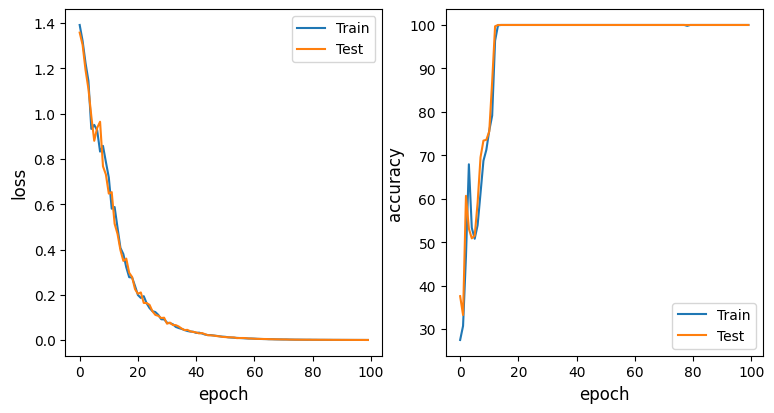

In [36]:
#setup data generator
difficulty = QRSU.DifficultyLevel.EASY
batch_size = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup RNN and training
input_size = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model = LSTM(input_size, hidden_size, output_size)
criterion = torch.nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs = 100

# train 
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

## Model evaluation

In [37]:
import collections
import random

def evaluate_model(model, difficulty, seed=9001, verbose=False):
    # Define a dictionary that maps class indices to labels
    class_idx_to_label = {0: 'Q', 1: 'R', 2: 'S', 3: 'U'}

    # Create a new data generator
    data_generator = QRSU.get_predefined_generator(difficulty, seed=seed)

    # Track the number of times a class appears
    count_classes = collections.Counter()

    # Keep correctly classified and misclassified sequences, and their
    # true and predicted class labels, for diagnostic information.
    correct = []
    incorrect = []

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    model.eval()

    with torch.no_grad():
        for batch_idx in range(len(data_generator)):
            data, target = test_data_gen[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            data_decoded = data_generator.decode_x_batch(data.cpu().numpy())
            target_decoded = data_generator.decode_y_batch(target.cpu().numpy())

            output = model(data)
            output = output[:, -1, :]

            target = target.argmax(dim=1)
            y_pred = output.argmax(dim=1)
            y_pred_decoded = [class_idx_to_label[y.item()] for y in y_pred]

            count_classes.update(target_decoded)
            for i, (truth, prediction) in enumerate(zip(target_decoded, y_pred_decoded)):
                if truth == prediction:
                    correct.append((data_decoded[i], truth, prediction))
                else:
                    incorrect.append((data_decoded[i], truth, prediction))

    num_sequences = sum(count_classes.values())
    accuracy = float(len(correct)) / num_sequences * 100
    print(f'The accuracy of the model is measured to be {accuracy:.2f}%.\n')

    # Report the accuracy by class
    for label in sorted(count_classes):
        num_correct = sum(1 for _, truth, _ in correct if truth == label)
        print(f'{label}: {num_correct} / {count_classes[label]} correct')

    # Report some random sequences for examination
    print('\nHere are some example sequences:')
    for i in range(10):
        sequence, truth, prediction = correct[random.randrange(0, 10)]
        print(f'{sequence} -> {truth} was labelled {prediction}')

    # Report misclassified sequences for investigation
    if incorrect and verbose:
        print('\nThe following sequences were misclassified:')
        for sequence, truth, prediction in incorrect:
            print(f'{sequence} -> {truth} was labelled {prediction}')
    else:
        print('\nThere were no misclassified sequences.')

In [38]:
evaluate_model(model, difficulty)

The accuracy of the model is measured to be 100.00%.

Q: 258 / 258 correct
R: 249 / 249 correct
S: 232 / 232 correct
U: 253 / 253 correct

Here are some example sequences:
BYbdYabE -> U was labelled U
BbXcXbcE -> Q was labelled Q
BcYacYbE -> U was labelled U
BdYcbXE -> S was labelled S
BbXaXdE -> Q was labelled Q
BcYacYbE -> U was labelled U
BbXcXbcE -> Q was labelled Q
BbXaXdE -> Q was labelled Q
BYdcaYbE -> U was labelled U
BcYdYdaE -> U was labelled U

There were no misclassified sequences.


## Visualize LSTM

[Epoch 100/100] loss: 0.5116, accuracy: 75.40% - test_loss: 0.4441, test_acc: 83.27%


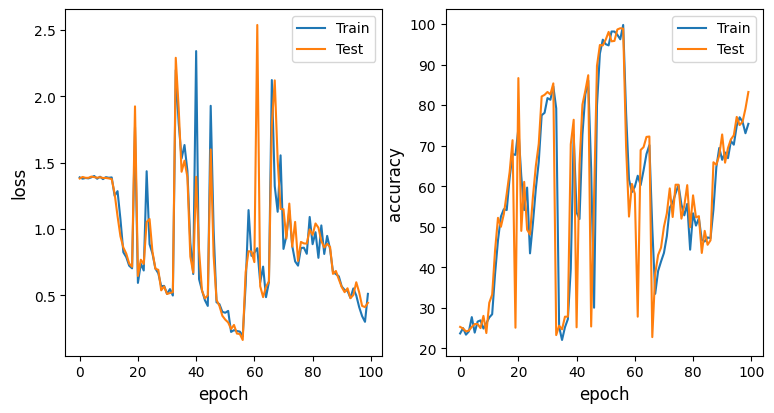

In [39]:
# For reproducibility
torch.manual_seed(1)

# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.MODERATE
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 12
output_size = train_data_gen.n_classes
model       = LSTM(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 100

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=False)

In [40]:
# Get hidden (H) and cell (C) batch state given a batch input (X)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.eval()
with torch.no_grad():
    data = test_data_gen[0][0]
    X = torch.from_numpy(data).float().to(device)
    H_t, C_t = model.get_states_across_time(X)

In [41]:
from matplotlib import pyplot as plt
import numpy as np
import torch
from IPython.display import HTML, display


def _cstr(s, color='black'):
    if s == ' ':
        return f'<text style=color:#000;padding-left:10px;background-color:{color}> </text>'
    else:
        return f'<text style=color:#000;background-color:{color}>{s} </text>'

def _print_color(t):
    display(HTML(''.join([_cstr(ti, color=ci) for ti, ci in t])))

def _get_clr(value):
    colors = ('#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8',
              '#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
              '#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
              '#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e')
    value = int((value * 100) / 5)
    if value == len(colors): value -= 1  # fixing bugs...
    return colors[value]


def print_colourbar():
    color_range = torch.linspace(-2.5, 2.5, 20)
    to_print = [(f'{x:.2f}', _get_clr((x+2.5)/5)) for x in color_range]
    _print_color(to_print)

print("Color range is as follows:")
print_colourbar()

Color range is as follows:


In [43]:
def _visualise_values(output_values, result_list):
    text_colours = []
    for i in range(len(output_values)):
        text = (result_list[i], _get_clr(output_values[i]))
        text_colours.append(text)
    _print_color(text_colours)
    
def plot_state(data, state, b, decoder):
    actual_data = decoder(data[b, :, :].numpy())
    seq_len = len(actual_data)
    seq_len_w_pad = len(state)
    for s in range(state.size(2)):
        states = torch.sigmoid(state[:, b, s])
        _visualise_values(states[seq_len_w_pad - seq_len:], list(actual_data))

plot_state(X.cpu(), C_t, b=9, decoder=test_data_gen.decode_x)  # 3, 6, 9


In [44]:
plot_state(X.cpu(), H_t, b=9, decoder=test_data_gen.decode_x)